In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm


## 0. Parameters <a name="parameters"></a>

In [ ]:
CHANNELS= 3
IMAGE_SIZE = 32
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 10
EPOCHS = 30
BETA = 1

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

--2024-10-12 02:23:21--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.2’

train_32x32.mat.2   100%[===================>] 173.61M  2.37MB/s    in 42s     

2024-10-12 02:24:03 (4.09 MB/s) - ‘train_32x32.mat.2’ saved [182040794/182040794]

--2024-10-12 02:24:04--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.2’

test_32x32.mat.2    100%[===================>]  61.30M  4.60MB/s    in 14s     

2024-10-12 02:24:18 (4.25 MB/s) - ‘test_32x32.mat.2’ saved [642

In [ ]:
# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


## 2. Build the variational autoencoder <a name="build"></a>

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder part of the VAE
def build_encoder(IMAGE_SIZE, EMBEDDING_DIM):
    encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input")  # 3 channels for RGB

    x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

    shape_before_flattening = K.int_shape(x)[1:]
    x = layers.Flatten()(x)

    z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()

    return encoder, shape_before_flattening

# Decoder part of the VAE
def build_decoder(EMBEDDING_DIM, shape_before_flattening):
    decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

    x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
    x = layers.Reshape(shape_before_flattening)(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

    decoder_output = layers.Conv2D(3, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)  # 3 channels for RGB output

    decoder = models.Model(decoder_input, decoder_output)
    decoder.summary()

    return decoder

# VAE Model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
      # Extract input (ignoring target) in case data is passed as (input, target)
      if isinstance(data, tuple):
          data = data[0]

      with tf.GradientTape() as tape:
          z_mean, z_log_var, reconstruction = self(data)
          reconstruction_loss = tf.reduce_mean(
              BETA * losses.binary_crossentropy(data, reconstruction) * np.prod(data.shape[1:])
          )
          kl_loss = tf.reduce_mean(
              -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
          )
          total_loss = reconstruction_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
      # Extract input (ignoring target) in case data is passed as (input, target)
      if isinstance(data, tuple):
          data = data[0]

      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(
          BETA * losses.binary_crossentropy(data, reconstruction) * np.prod(data.shape[1:])
      )
      kl_loss = tf.reduce_mean(
          -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
      )
      total_loss = reconstruction_loss + kl_loss

      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }


# Function to build the VAE (without training)
def build_vae(IMAGE_SIZE, EMBEDDING_DIM):
    encoder, shape_before_flattening = build_encoder(IMAGE_SIZE, EMBEDDING_DIM)
    decoder = build_decoder(EMBEDDING_DIM, shape_before_flattening)

    vae = VAE(encoder, decoder)

    return vae


## 3. Train the variational autoencoder <a name="train"></a>

In [ ]:
# Compile the variational autoencoder
def train_vae(vae, x_train, x_test, BETA, EPOCHS, BATCH_SIZE):
    optimizer = optimizers.Adam(learning_rate=0.0005)
    vae.compile(optimizer=optimizer, loss=losses.binary_crossentropy)

    # Train the VAE
    vae.fit(
        x_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(x_test, x_test),
    )

# Function to compile and test the VAE (use this for testing separately)
def test_vae(vae, x_test, BETA):
    # Test the VAE (validation)
    results = vae.evaluate(x_test)
    return results
vae = build_vae(IMAGE_SIZE, EMBEDDING_DIM)  # Build the model
train_vae(vae, x_train, x_test, BETA, EPOCHS, BATCH_SIZE)  # Train the model
results = test_vae(vae, x_test, BETA)  # Test the model
print("Test results:", results)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_19 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_19[0][0]']           
                                                                                            

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

1/1 [==============================] - 0s 165ms/step
Example real clothing items:


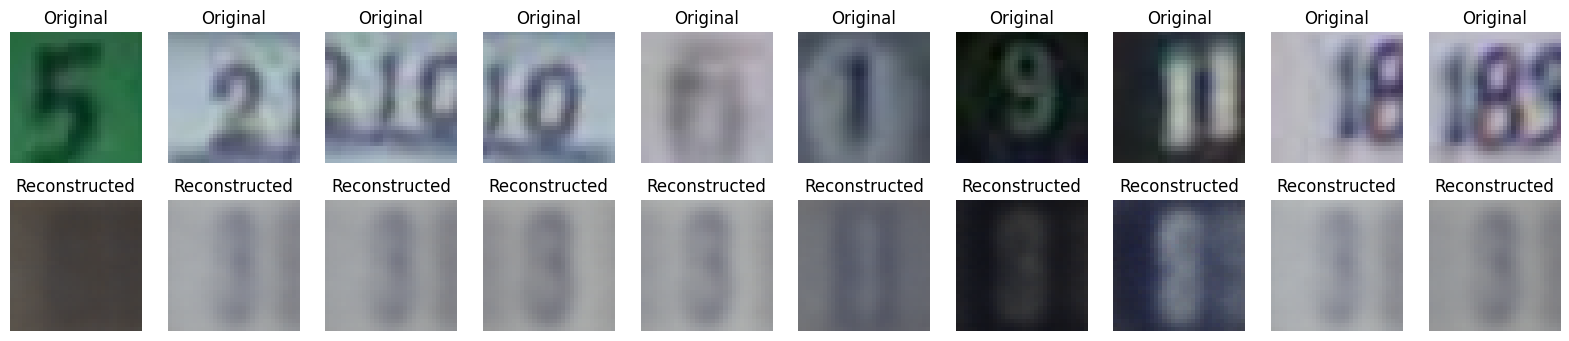

In [ ]:


# Select a subset of the test set
n_to_predict = 10  # Displaying fewer images for visualization; adjust as needed
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

# Create VAE predictions
_, _, reconstructions = vae.predict(example_images)

# Function to display images in grid
def display_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(20, 4))

    for i in range(n):
        # Display original images
        axes[0, i].imshow(original_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Display reconstructed images
        axes[1, i].imshow(reconstructed_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.show()

# Display the example images and reconstructions)
display_images(example_images, reconstructions, n_to_predict)


## 4. Explore the latent space <a name="explore"></a>

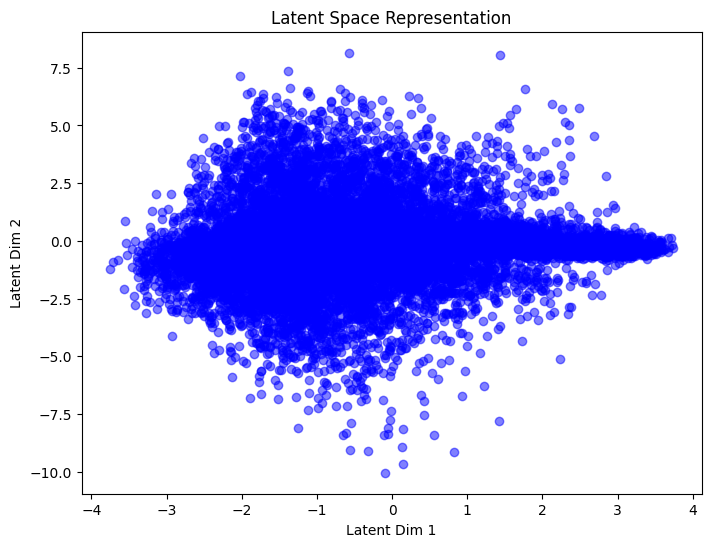

In [ ]:
def visualize_latent_space(vae, x_test):
    # Encode test images into the latent space
    z_mean, z_log_var, _ = vae.encoder(x_test)

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue', alpha=0.5)
    plt.title("Latent Space Representation")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.show()

# Call the function to visualize the latent space
visualize_latent_space(vae, x_test)




### Discussion Question:

Clarity: I noticed that the more I increased the latent dim, the less blurry they got, but blurry for the most part overall.

Distortion: A lot of the reconstructions are very distorted.

Variability: The variability is not good, which means I need to update the testing function

Generalization: Lacking due to a lackluster testing model
